## 1. PURPOSE

Our main aim is to build two models to predict ball $(x, y)$ location on each axis seperately.

Detailed info on features and their calculations can be found on classes.FeatureBuilder. Target data is derived from a player who owns the ball. So if some player has the ball then it's location is selected as a ball location. This approach has some disadvantages.

In [1]:
import pandas as pd
import numpy as np
import datetime
from keras.models import load_model
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.regularizers import l2,l1
from sklearn.preprocessing import StandardScaler

# nn trainer class
from classes.NNBuilder import *
from classes.DataModel import *
from classes.FeatureBuilder import *
# utility functions
from classes.Utils import *

Using TensorFlow backend.


#### Get data

In [22]:
# get dataset
try:
    train_df = pd.read_csv('dataset/data_train.csv').dropna().reset_index(drop=True)
except FileNotFoundError:
    raise FileNotFoundError

In [23]:
# dataModel = DataModel()
# featureBuilder = FeatureBuilder(dataModel.get_role_list())
# feature_list = featureBuilder.get_feature_labels()
# leave the y-axis related features out if you select x-axis and other seperate features, and do vice versa on y-axis
# features = [False if '_y' in name[-2:] else True for name in feature_list]

In [24]:
# get values
X_train = train_df[train_df['y']>0].iloc[:, 7:]# .loc[:, features] => use this if you want to select specific features
y_train = train_df[train_df['y']>0]['y'] # x>0 menas that game state is 1
del train_df

In [25]:
display(X_train.head(6))
print('n_samples\t= {}\nn_features\t= {}'.format(*X_train.shape))

,home_LB_all_avrg_x,home_LB_all_avrg_y,home_LB_all_avrg_speed,home_LB_all_avrg_direction_x,home_LB_all_avrg_direction_y,home_LB_all_inner_dis_to_avrg_pos,home_LB_slow_avrg_x,home_LB_slow_avrg_y,home_LB_slow_avrg_speed,home_LB_hir_avrg_x,...,bothteams_inner_dis_to_avrg_pos,bothteams_dbscan_avrg_x,bothteams_dbscan_avrg_y,bothteams_dbscan_avrg_speed,bothteams_inner_dis_to_dbscan_pos,referee_x,referee_y,referee_speed,referee_direction_x,referee_direction_y
1,34.61,15.08,1.58,1,1,0.0,-1.00,-1.00,-1.00,34.61,...,401.82,51.76,38.09,1.89,63.45,50.79,42.71,1.50,-1,-1
2,34.40,17.08,2.09,-1,1,0.0,-1.00,-1.00,-1.00,34.40,...,434.41,48.46,39.90,3.21,88.26,48.74,43.57,2.80,-1,1
3,33.74,18.55,1.21,-1,1,0.0,33.74,18.55,1.21,-1.00,...,438.13,47.19,42.64,3.18,88.96,46.49,45.56,2.99,-1,1
4,33.70,19.55,1.22,-1,1,0.0,33.70,19.55,1.22,-1.00,...,447.82,48.02,49.20,2.54,146.11,45.85,47.91,2.54,-1,1
5,34.77,20.37,1.54,1,1,0.0,-1.00,-1.00,-1.00,34.77,...,454.63,47.69,47.09,2.51,110.32,47.95,49.01,3.01,1,1
6,36.15,19.89,1.60,1,-1,0.0,-1.00,-1.00,-1.00,36.15,...,455.47,50.63,45.14,3.41,116.43,50.95,47.47,4.01,1,-1


n_samples	= 834160
n_features	= 299


In [26]:
# shuffle data
X_train, y_train = shuffle(X_train, y_train)

In [27]:
# scale values 
scaler = StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)

## 2. TRAIN & OPTIMIZING

In this part training and parameters search for best nn structure will be conducted. Best parameters will be defined by comparing accuracy on validation set. Training will be done *for each axis seperatley*. 

***Note:*** First add regularization but dropout was better then changed my mind.

In [28]:
## NN STRUCTURES 
nn_structures = {  
    
# create the desired nn structur
# in the next stage, we only assig value to parameters those have null value 

                0:{'input': { 'layer': None, 'activation': None},
                'dropout0': {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'hidden1':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}},
    
    
                1:{'input': { 'layer': None, 'activation': None},
                'dropout0': {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'hidden1':  { 'layer': 400, 'activation': None},
                'hidden2':  { 'layer': 500, 'activation': None},
                'hidden3':  { 'layer': 600, 'activation': None},
                'hidden4':  { 'layer': 500, 'activation': None},
                'hidden5':  { 'layer': 400, 'activation': None},
                'hidden6':  { 'layer': None, 'activation': None},
                'hidden7':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}},
    
    
                2:{'input': { 'layer': None, 'activation': None},
                'dropout0': {'ratio': 0.2},
                'hidden0':  { 'layer': None, 'activation': None},
                'hidden1':  { 'layer': 200, 'activation': None},
                'hidden2':  { 'layer': 100, 'activation': None},
                'hidden3':  { 'layer': 50, 'activation': None},
                'hidden4':  { 'layer': 100, 'activation': None},
                'hidden5':  { 'layer': 200, 'activation': None},
                'hidden6':  { 'layer': None, 'activation': None},
                'hidden7':  { 'layer': None, 'activation': None},
                'output':   { 'layer': 1, 'activation': None}},

    
    
                3:{'input': {'layer': None, 'activation': None, 'kernel_regularizer': 0.001},
                'hidden0':  { 'layer': None, 'activation': None, 'kernel_regularizer': 0.001},
                'hidden1':  { 'layer': None, 'activation': None, 'kernel_regularizer': 0.001},
                'hidden2':  { 'layer': None, 'activation': None, 'kernel_regularizer': 0.001},
                'hidden3':  { 'layer': None, 'activation': None, 'kernel_regularizer': 0.001},
                'hidden4':  { 'layer': None, 'activation': None, 'kernel_regularizer': 0.001},
                'output':   { 'layer': 1, 'activation': None}}

                }


In [29]:
# PARAMS GIRD
param_grid = [
    {      
            'dense': [140, 170, 201, 299],
            'activation': ['relu'],
            'optimizer': ['adam', 'Adadelta']
    }
]


# CREATE ITERATIVE PARAM LIST
para_label=['dense', 'activation', 'optimizer']

# parameter list for storing all possible combinations
param_list = []

# create all possible parameters combinations for optimizations
for n_dense in param_grid[0]['dense']:
        for n_act in param_grid[0]['activation']:
            for n_opt in param_grid[0]['optimizer']:
                param_dict = dict(zip(para_label, [n_dense, n_act, n_opt]))
                param_list.append(param_dict)

#### TRNAING

In [1]:
# overview: select the model with best (last) validation accuracy

# initial parameter accumulators
tmp_val_acc = 10**3
best_model = None
best_model_params = {}
best_model_history = None

# initial log accumulators
fmt = 'Training has ended in {} minutes and {} seconds\n'

# initial accumulator for storing result along with layer dense and size
all_result = []

# iterate through nn_strcuture
nn_structures_loop = nn_structures

for nn_key , nn_value in nn_structures_loop.items():
    
    # ----------------- GET PARAMETERS -----------------
    
    # iterate through parameters   
    for param_i,_ in enumerate(param_list):
        
        # get paramas
        dense_p = param_list[param_i]['dense']
        activation_p = param_list[param_i]['activation']
        optimizer_p = param_list[param_i]['optimizer']
        
        # set current nn_structure
        # assign value to those with null values
        for nn_inner_key , nn_inner_value in nn_value.items():
            try:
                
                if 'layer' in nn_inner_value and nn_inner_key!='output':
                    if nn_structures[nn_key][nn_inner_key]['layer']==None:
                        nn_inner_value['layer']=dense_p
                if 'activation' in nn_inner_value:
                    if nn_structures[nn_key][nn_inner_key]['activation']==None:
                        nn_inner_value['activation']=activation_p
                    
            except KeyError:
                pass

#         for k, v in nn_value.items():
#             print(v)
#         print('optimizer: {}'.format(optimizer_p))
        
        
        # ----------------- TRAIN MODEL -----------------
        
        nnBuilder = NNBuilder(input_shape = X_train.shape[1]) # init nn builder

        nnBuilder.init_model(nn_value) # init model
        model=nnBuilder.get_model() # get model
        

        # compile model parameters
        model.compile(optimizer=optimizer_p, loss='mean_squared_error', metrics=['mae'])

        # we will measure time elapsed
        t_beg = datetime.datetime.now()
        
        # train and get history
        hist = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_split=0.18, verbose=0)
            
        # set pest params
        if hist.history['val_loss'][-1]<tmp_val_acc:
            tmp_val_acc = hist.history['val_loss'][-1]
            best_model_params = {'nn':nn_value, 'optimizer':optimizer_p}
            best_model_history = hist
            best_model = model
            
        # ----------------- STORE RESULT FOR EVALUATION -----------------
        
        # store loss and val_loss results to comapre performance with respect to dense and hidden layer size
        all_result.append({'val_loss':round(hist.history['val_loss'][-1], 2), 
                   'loss':round(hist.history['loss'][-1], 2), 
                   'nn-layers':sum([True if ('hidden' in key) else False for key in nn_value.keys()]), 
                   'nn-dense': dense_p,
                   'optimizer': optimizer_p,
                   'model': model,
                   'history': hist})
        
        # build up message with training results
        final_train_result_msg='\n1. MODEL\n'
        for keys, content in nn_value.items():
            final_train_result_msg += '{}: {}\n'.format(keys, content)

        final_train_result_msg += '\n2. RESULTS\n'
        for metric in hist.params['metrics']:
            final_train_result_msg += '{}: {}\n'.format(metric, round(hist.history[metric][-1], 4))
                            
        
        # time traing ended
        t = datetime.datetime.now() - t_beg
        sec = t.seconds
        minutes = sec//60
        seconds = sec - 60*minutes
    
        # write the traing log to a file
        header='DATETIME: {}'.format(str(datetime.datetime.now()))
        with open('models/{path}/{file}.txt'.format(path='logs', file=('y_reg_grid_search_results')), 'a') as f:
            f.write('{}\n{}\n'.format(header, '-'*len(header)) + fmt.format(minutes, seconds) + final_train_result_msg +'\n\n')

        # Deletes the existing model
        del model
        del nnBuilder
        
        
# save model
best_model.save('models/{path}/{model}.h5'.format(path='nn', model=('ballpos_y_reg_2')))
del best_model

## 3. RESULTS

## *3.1 X-axis*

#### Result of gird search

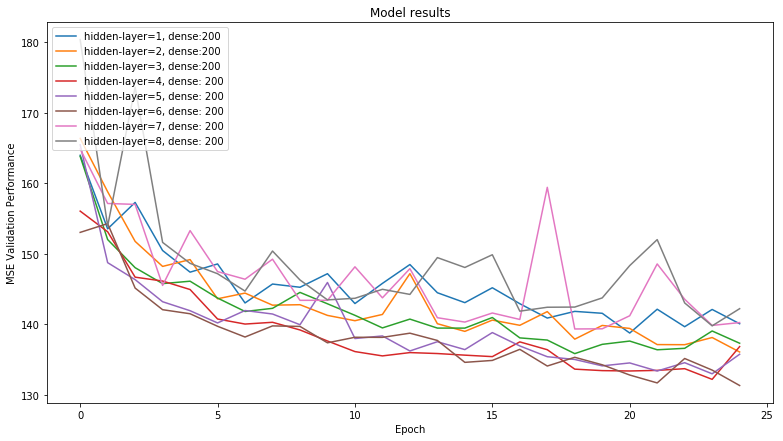

In [207]:
# initial value accumulators 
value_loss=[]
label=[]

for result_i in all_result: 
    value_loss.append(result_i['history'].history['val_loss']) # get history values
    label.append('hidden-layer:{}, dense:{}'.format(result_i['nn-layers'], result_i['nn-dense'])) # get label info
    
    
plot_model_history(value_loss, label, title='Model results', ylabel='MSE Validation Performance', xlabel='Epoch', figure_size=(13,7))

Many experiments were conducted to find the model that has the best generalization ability. Different neural networks structures, with various node size, layer size and regularization methods, are examined. Then each structure tested with different optimization and activation values. You can find all logs of all experiments on x_reg_grid_search_results.txt file.

Important findings: 
* The overall performance of the model depends on the size of the hidden layer (the above figure depicts how the hidden-layer size affected the performance). 
* More densely connected the layers are, better they perform.
* Relu was the best activation algorithm.
* Adam worked as the best optimizer.

#### Best Model Performance

In [212]:
# best nn strucutre
best_model_params

{'nn': {'input': {'layer': 299, 'activation': 'relu'},
  'dropout0': {'ratio': 0.2},
  'hidden1': {'layer': 299, 'activation': 'relu'},
  'hidden2': {'layer': 299, 'activation': 'relu'},
  'hidden3': {'layer': 299, 'activation': 'relu'},
  'hidden4': {'layer': 299, 'activation': 'relu'},
  'output': {'layer': 1, 'activation': 'relu'}},
 'optimizer': 'adam'}

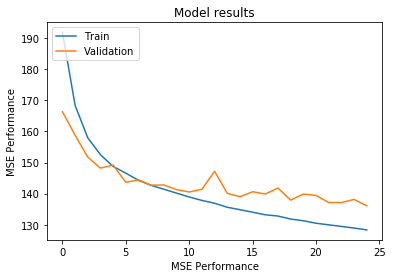

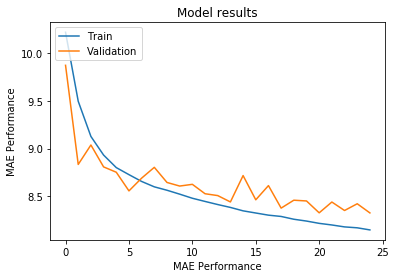

In [148]:
value_loss=[best_model_history.history['loss'], best_model_history.history['val_loss']]
value_mae=[best_model_history.history['mean_absolute_error'], best_model_history.history['val_mean_absolute_error']]
label=['Train', 'Validation']

plot_model_history(value_loss, label, 'Model results', ylabel='MSE Performance', xlabel='Epoch', figure_size=(6,4))
plot_model_history(value_mae, label, 'Model results', ylabel='MAE Performance', xlabel='Epoch', figure_size=(6,4))

#### Final Performance on Train and Validation sets

In [149]:
print('Train RMSE: {} meters'.format(str(round(math.sqrt(best_model_history.history['loss'][-1]), 2))))
print('Validation RMSE: {} meters \n'.format(str(round(math.sqrt(best_model_history.history['val_loss'][-1]), 2))))

print('Train MAE: {} meters'.format(str(round(best_model_history.history['mean_absolute_error'][-1], 2))))
print('Validation MAE: {} meters'.format(str(round(best_model_history.history['val_mean_absolute_error'][-1], 2))))

Train RMSE: 11.33 meters
Validation RMSE: 11.67 meters 

Train MAE: 8.25 meters
Validation MAE: 8.43 meters


### Result on the test set
The results are examined on 31 unseen matches.

In [36]:
# get test dataset
try:
    test_df = pd.read_csv('dataset/data_test.csv').dropna().reset_index(drop=True)
except FileNotFoundError:
    raise FileNotFoundError

In [37]:
# get values
X_test = test_df[test_df['x']>0].iloc[:, 7:]
y_test = test_df[test_df['x']>0]['x']
del test_df

print('n_samples\t= {}\nn_features\t= {}'.format(*X_test.shape))

n_samples	= 92078
n_features	= 299


In [38]:
# shuffle data
X_test, y_test = shuffle(X_test, y_test)

In [39]:
X_test = scaler.transform(X_test)

In [40]:
# Load model
model = load_model('models/nn/ballpos_x_reg.h5')

In [151]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f meters" % (model.metrics_names[0], math.sqrt(score[0])))
print("%s: %.2f meters" % (model.metrics_names[1], score[1]))

loss: 12.63 meters
mean_absolute_error: 9.06 meters


## *3.2 Y-axis*

#### Result of gird search

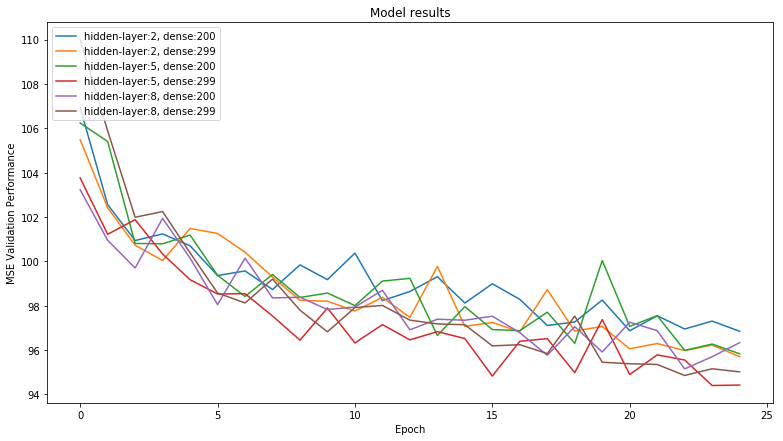

In [27]:
# # initial value accumulators 
value_loss=[]
label=[]

for result_i in all_result: 
    value_loss.append(result_i['history'].history['val_loss']) # get history values
    label.append('hidden-layer:{}, dense:{}'.format(result_i['nn-layers'], result_i['nn-dense'])) # get label info
    
    
plot_model_history(value_loss, label, title='Model results', ylabel='MSE Validation Performance', xlabel='Epoch', figure_size=(13,7))

In [76]:
# best nn strucutre
best_model_params

{'nn': {'input': {'layer': 299, 'activation': 'relu'},
  'dropout0': {'ratio': 0.2},
  'hidden0': {'layer': 299, 'activation': 'relu'},
  'hidden1': {'layer': 299, 'activation': 'relu'},
  'hidden2': {'layer': 299, 'activation': 'relu'},
  'hidden3': {'layer': 299, 'activation': 'relu'},
  'hidden4': {'layer': 299, 'activation': 'relu'},
  'hidden5': {'layer': 299, 'activation': 'relu'},
  'hidden6': {'layer': 299, 'activation': 'relu'},
  'hidden7': {'layer': 299, 'activation': 'relu'},
  'output': {'layer': 1, 'activation': 'relu'}},
 'optimizer': 'adam'}

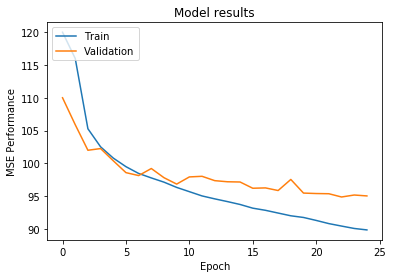

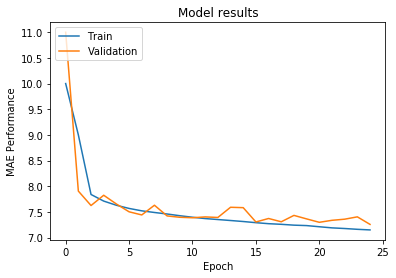

In [72]:
value_loss=[best_model_history.history['loss'], best_model_history.history['val_loss']]
value_mae=[best_model_history.history['mean_absolute_error'], best_model_history.history['val_mean_absolute_error']]
label=['Train', 'Validation']

plot_model_history(value_loss, label, 'Model results', ylabel='MSE Performance', xlabel='Epoch', figure_size=(6,4))
plot_model_history(value_mae, label, 'Model results', ylabel='MAE Performance', xlabel='Epoch', figure_size=(6,4))

In [71]:
print('Train RMSE: {} meters'.format(str(round(math.sqrt(best_model_history.history['loss'][-1]), 2))))
print('Validation RMSE: {} meters \n'.format(str(round(math.sqrt(best_model_history.history['val_loss'][-1]), 2))))

print('Train MAE: {} meters'.format(str(round(best_model_history.history['mean_absolute_error'][-1], 2))))
print('Validation MAE: {} meters'.format(str(round(best_model_history.history['val_mean_absolute_error'][-1], 2))))

Train RMSE: 9.48 meters
Validation RMSE: 9.75 meters 

Train MAE: 7.15 meters
Validation MAE: 7.26 meters


### Result on the test set
The results are examined on 31 unseen matches.

In [43]:
# get test dataset
try:
    test_df = pd.read_csv('dataset/data_test.csv').dropna().reset_index(drop=True)
except FileNotFoundError:
    raise FileNotFoundError

In [44]:
# get values
X_test = test_df[test_df['y']>0].iloc[:, 7:]
y_test = test_df[test_df['y']>0]['y']
del test_df

print('n_samples\t= {}\nn_features\t= {}'.format(*X_test.shape))

n_samples	= 91871
n_features	= 299


In [45]:
# shuffle data
X_test, y_test = shuffle(X_test, y_test)
X_test = scaler.transform(X_test)

In [47]:
# Load model
model = load_model('models/nn/ballpos_y_reg.h5')

In [68]:
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f meters" % (model.metrics_names[0], math.sqrt(score[0])))
print("%s: %.2f meters" % (model.metrics_names[1], score[1]))

loss: 10.29 meters
mean_absolute_error: 7.65 meters


### Overall Summary of model


The promising prediction has been observed in test sets
when applying previously trained models to track a ball on
unseen matches; however, during typical long passing when the
ball changes location halfway through the other side, it
was observed that the regression model cannot identify these
changes for the first few frames. Moreover, when a goalkeeper
starts the game, or a player takes free-kick or corner, the model
prediction focuses on the player groups rather than a player
who is with the ball.
